## Goodreads UCF Recommender
In this project a **UCF** (User-based Collaborative Filtering) Recommender is implemented in order to recommend books to users.    
  
Dataset that is used in this project can be found [here](https://github.com/zygmuntz/goodbooks-10k).
### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import os.path as path
from tempfile import mkdtemp
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

/home/ghazal/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


### Defining Constants

In [2]:
RATING = 3
USER_ID = 1
BOOK_ID = 2
TEST_SIZE = 0.1
RATINGS_PATH = 'Datasets'

### Importing Data

In [3]:
ratings_file = path.join(RATINGS_PATH, 'ratings.csv')
ratings = pd.read_csv(ratings_file)
n_users = ratings.user_id.unique().shape[0]
n_books = ratings.book_id.unique().shape[0]

### Shuffling Data

In [4]:
ratings = ratings.sample(frac=1)

### Spliting Data to Train and Test

In [5]:
train, test = train_test_split(ratings, test_size=TEST_SIZE)

### Basic Statistical Details of Training Data

In [6]:
train.describe()

user_id       book_id        rating
count  5.378831e+06  5.378831e+06  5.378831e+06
mean   2.622559e+04  2.006428e+03  3.919947e+00
std    1.541152e+04  2.468304e+03  9.909826e-01
min    1.000000e+00  1.000000e+00  1.000000e+00
25%    1.281500e+04  1.980000e+02  3.000000e+00
50%    2.593900e+04  8.850000e+02  4.000000e+00
75%    3.950900e+04  2.972000e+03  5.000000e+00
max    5.342400e+04  1.000000e+04  5.000000e+00

### Histogram of Ratings in Training Data

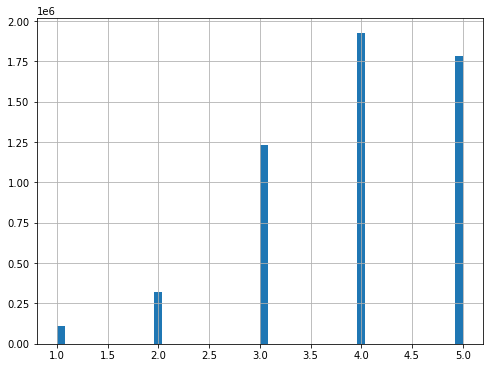

In [7]:
train['rating'].hist(figsize=(8.0, 6), bins=50)
plt.show()

### Concise Summary of Training Data 

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5378831 entries, 5094735 to 1217020
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 164.1 MB


In [9]:
train.head()

user_id  book_id  rating
5094735    49805     2832       5
1927647    10104     6123       4
3492979     1384     4887       4
3632969    34744       18       5
235608       504      186       4

### Creating User-Item Matrices

In [10]:
train_file = path.join(mkdtemp(), 'train.dat')
train_matrix = np.memmap(train_file, dtype='float64', mode='w+', shape=(n_users, n_books))

for row in train.itertuples():
    train_matrix[row[USER_ID]-1, row[BOOK_ID]-1] = row[RATING]

In [11]:
print(train_matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [4. 5. 0. ... 0. 0. 0.]
 [4. 5. 0. ... 0. 0. 0.]
 [0. 5. 4. ... 0. 0. 0.]]


In [12]:
test_file = path.join(mkdtemp(), 'test.dat')
test_matrix = np.memmap(test_file, dtype='float64', mode='w+', shape=(n_users, n_books))

for row in test.itertuples():
    test_matrix[row[USER_ID]-1, row[BOOK_ID]-1] = row[RATING]

### Computing Similarities
In this part the cosine is used as a metric to compute the similarity between two users.
### $sim(u,v)=\cos(\theta)=\frac{r_{u}.r_{v}}{\|r_{u}\|\|r_{v}\|}=\sum_{i}^{}\frac{r_{ui}r_{vi}}{\sqrt{\sum_{i}^{}r_{ui}^2}\sqrt{\sum_{i}^{}r_{vi}^2}}$

In [13]:
sim_file = path.join(mkdtemp(), 'sim.dat')
similarities = np.memmap(sim_file, dtype='float64', mode='w+', shape=(n_users, n_users))

def compute_similarities(epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    similarities = train_matrix.dot(train_matrix.T) + epsilon
    similarities /= np.array([np.sqrt(np.diagonal(similarities))])
    similarities /= np.array([np.sqrt(np.diagonal(similarities))]).T

In [ ]:
compute_similarities()
print(similarities)

### Computing Predictive Model
### $score(u,i)=\bar{r_{u}}+\frac{\sum_{v}^{}(r_{vi}-\bar{r_{v}})\times{w_{uv}}}{\sum_{v}^{}w_{uv}}$

In [ ]:
model_file = path.join(mkdtemp(), 'model.dat')
predictive_model = np.memmap(model_file, dtype='float64', mode='w+', shape=(n_users, n_books))

def compute_predictive_model(rating_matrix, similarities):
    mean_rating = train_matrix.mean(axis=1)
    diff_file = path.join(mkdtemp(), 'diff.dat')
    ratings_diff = np.memmap(diff_file, dtype='float64', mode='w+', shape=(n_users, n_books))
    ratings_diff = (train_matrix - mean_rating[:, np.newaxis])
    predictive_model = mean_rating[:, np.newaxis] + similarities.dot(ratings_diff) / \
    np.array([np.abs(similarities).sum(axis=1)]).T

In [ ]:
compute_predictive_model()
print(predictive_model)

### Evaluating Prediction Accuarcy
**RMSE** (root mean squared error) is used as a metric to evaluate prediction accuracy. 
### $RMSE=\sqrt{\frac{\sum_{ratings}^{}(P-R)^2}{\# ratings}}$

In [ ]:
def evaluate_prediction_accuracy():
    predictive_model = predictive_model[test_matrix.nonzero()].flatten()
    test_matrix = test_matrix[test_matrix.nonzero()].flatten()
    rmse = sqrt(mean_squared_error(predictive_model, test_matrix))
    
    return rmse

In [ ]:
rmse = evaluate_prediction_accuracy()
print('RMSE =',rmse)